/Users/aliefchandrawijaya/trading_bot/venv/lib/python3.11/site-packages/pandas_ta/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


✅ 1. Libraries imported successfully.

🔄 2. Fetching multi-timeframe historical data for Intraday...
   Fetching H1 data...
   Resampling H1 data to create H4 data (Layar 1)...
   Fetching M15 data (Layar 3)...

   ✅ Successfully fetched and processed 8231 H4, 32918 H1, and 131653 M15 candles.

🛠️  3. Calculating indicators for all timeframes...
   Indicators calculated successfully.

⚙️  4. Running Intraday Triple Screen backtesting...
   Backtesting simulation complete.

📊 5. Analyzing performance and creating plot...

--- Intraday Backtest Results ---
Total Trades: 375
Win Rate: 51.20%
Profit Factor: 2.39
------------------------



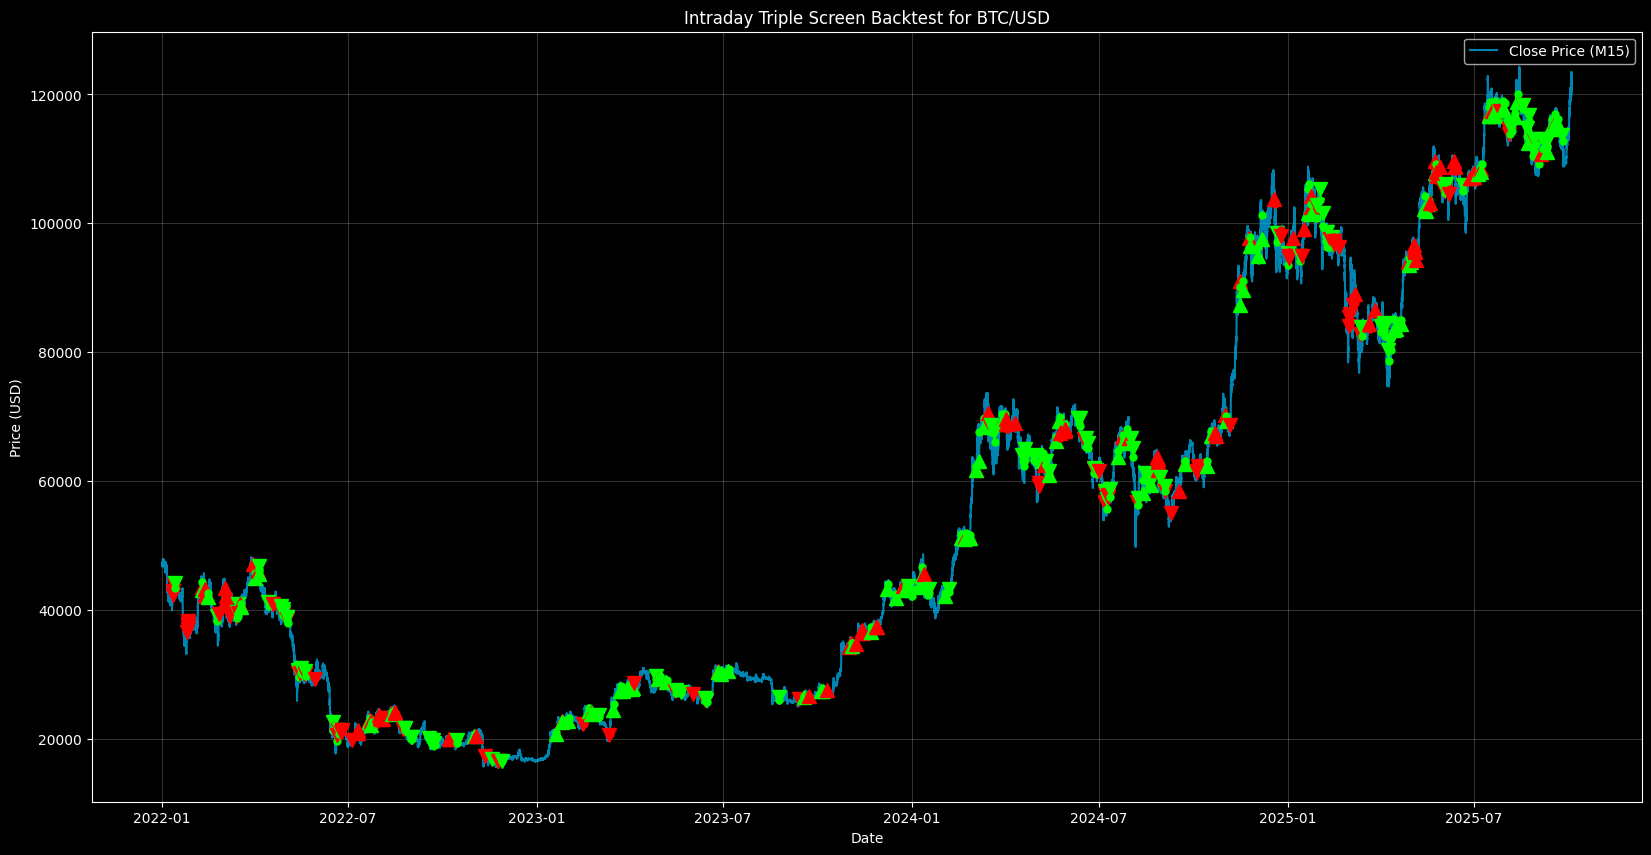

In [1]:
# ==============================================================================
# STRATEGI "TRIPLE SCREEN INTRADAY" (H4 -> H1 -> M15) - V1.2 (RESAMPLING FIX)
# ==============================================================================

# === 1. SETUP & IMPORT LIBRARY ===
import pandas as pd
import numpy as np
import ccxt
import pandas_ta as ta
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os
from IPython.display import display
import time

print("✅ 1. Libraries imported successfully.")


# === 2. MULTI-TIMEFRAME DATA FETCHING (DENGAN RESAMPLING) ===
print("\n🔄 2. Fetching multi-timeframe historical data for Intraday...")
df_h4 = pd.DataFrame()
df_h1 = pd.DataFrame()
df_m15 = pd.DataFrame()
try:
    exchange = ccxt.coinbaseadvanced()
    exchange.proxies = {'http': None, 'https': None}
    symbol_input = 'BTC/USD'
    start_date = "2022-01-01"
    ccxt_symbol = symbol_input.replace('/', '-')
    since = exchange.parse8601(f"{start_date} 00:00:00Z")

    # --- Fetch Data H1 (Untuk Layar 2 dan untuk di-resample ke H4) ---
    print("   Fetching H1 data...")
    all_ohlcv_h1 = []
    while True:
        ohlcv_chunk = exchange.fetch_ohlcv(ccxt_symbol, '1h', since, limit=300)
        if not ohlcv_chunk: break
        all_ohlcv_h1.extend(ohlcv_chunk)
        since = ohlcv_chunk[-1][0] + 1
        time.sleep(exchange.rateLimit / 1000)
    df_h1 = pd.DataFrame(all_ohlcv_h1, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df_h1['timestamp'] = pd.to_datetime(df_h1['timestamp'], unit='ms')
    df_h1.set_index('timestamp', inplace=True)
    
    # --- BUAT DATA H4 (Layar 1) DARI DATA H1 ---
    print("   Resampling H1 data to create H4 data (Layar 1)...")
    agg_dict = {'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'}
    df_h4 = df_h1.resample('4H', origin='start_day').agg(agg_dict).dropna()

    # --- Fetch Data M15 (Layar 3) ---
    print("   Fetching M15 data (Layar 3)...")
    since_m15 = exchange.parse8601(f"{start_date} 00:00:00Z")
    all_ohlcv_m15 = []
    while True:
        ohlcv_chunk = exchange.fetch_ohlcv(ccxt_symbol, '15m', since_m15, limit=300)
        if not ohlcv_chunk: break
        all_ohlcv_m15.extend(ohlcv_chunk)
        since_m15 = ohlcv_chunk[-1][0] + 1
        time.sleep(exchange.rateLimit / 1000)
    df_m15 = pd.DataFrame(all_ohlcv_m15, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df_m15['timestamp'] = pd.to_datetime(df_m15['timestamp'], unit='ms')

    print(f"\n   ✅ Successfully fetched and processed {len(df_h4)} H4, {len(df_h1)} H1, and {len(df_m15)} M15 candles.")

except Exception as e:
    print(f"   ❌ ERROR during data fetching: {type(e).__name__} - {e}")

if not df_h4.empty and not df_h1.empty and not df_m15.empty:
    # (Sisa kode dari langkah 3 sampai 5 tetap sama persis, tidak perlu diubah, hanya perlu menyesuaikan nama variabel dari df_h6 ke df_h4)
    # === 3. CALCULATE INDICATORS ===
    print("\n🛠️  3. Calculating indicators for all timeframes...")
    
    df_h4['EMA_55'] = ta.ema(df_h4['close'], length=55)
    
    df_h1['RSI_14'] = ta.rsi(df_h1['close'], length=14)
    df_h1['ATR_14'] = ta.atr(df_h1['high'], df_h1['low'], df_h1['close'], length=14)
    peak_indices, _ = find_peaks(df_h1['high'], distance=5, prominence=df_h1['ATR_14'].mean())
    trough_indices, _ = find_peaks(-df_h1['low'], distance=5, prominence=df_h1['ATR_14'].mean())
    df_h1['swing_high'] = np.nan; df_h1.loc[df_h1.index[peak_indices], 'swing_high'] = df_h1['high'].iloc[peak_indices]
    df_h1['swing_low'] = np.nan; df_h1.loc[df_h1.index[trough_indices], 'swing_low'] = df_h1['low'].iloc[trough_indices]

    df_m15['EMA_21'] = ta.ema(df_m15['close'], length=21)
    df_m15['ATR_14'] = ta.atr(df_m15['high'], df_m15['low'], df_m15['close'], length=14)
    
    df_h4.dropna(inplace=True); df_h1.dropna(inplace=True, subset=['RSI_14']); df_m15.dropna(inplace=True)
    df_m15.reset_index(inplace=True)
    print("   Indicators calculated successfully.")

    # === 4. INTRADAY BACKTESTING ENGINE ===
    print("\n⚙️  4. Running Intraday Triple Screen backtesting...")
    trades = []
    in_position = False
    position_type = None; entry_price = 0; stop_loss = 0; take_profit = 0; entry_timestamp = None

    for i in range(1, len(df_m15)):
        current_time = df_m15['timestamp'].iloc[i]

        if in_position:
            if (position_type == 'BUY' and df_m15['low'].iloc[i] <= stop_loss) or \
               (position_type == 'SELL' and df_m15['high'].iloc[i] >= stop_loss):
                trades.append({'entry_timestamp': entry_timestamp, 'exit_timestamp': current_time, 'type': position_type, 'entry_price': entry_price, 'exit_price': stop_loss, 'result': 'loss'})
                in_position = False
            elif (position_type == 'BUY' and df_m15['high'].iloc[i] >= take_profit) or \
                 (position_type == 'SELL' and df_m15['low'].iloc[i] <= take_profit):
                trades.append({'entry_timestamp': entry_timestamp, 'exit_timestamp': current_time, 'type': position_type, 'entry_price': entry_price, 'exit_price': take_profit, 'result': 'win'})
                in_position = False

        if not in_position:
            h4_check = df_h4[df_h4.index < current_time]
            if h4_check.empty: continue
            is_uptrend = h4_check['close'].iloc[-1] > h4_check['EMA_55'].iloc[-1]
            
            h1_check = df_h1[df_h1.index < current_time]
            if h1_check.empty: continue
            
            pullback_signal = False
            if is_uptrend:
                last_highs = h1_check[h1_check['swing_high'].notna()]; last_lows = h1_check[h1_check['swing_low'].notna()]
                if not last_highs.empty and not last_lows.empty:
                    last_high_idx = last_highs.index[-1]; relevant_lows = last_lows[last_lows.index < last_high_idx]
                    if not relevant_lows.empty:
                        last_low_idx = relevant_lows.index[-1]
                        sh, sl = h1_check['swing_high'].loc[last_high_idx], h1_check['swing_low'].loc[last_low_idx]
                        f_0618 = sh - (sh - sl) * 0.618
                        if h1_check['close'].iloc[-1] <= f_0618 and h1_check['RSI_14'].iloc[-1] < 45:
                            pullback_signal = True
            else: # is_downtrend
                last_highs = h1_check[h1_check['swing_high'].notna()]; last_lows = h1_check[h1_check['swing_low'].notna()]
                if not last_highs.empty and not last_lows.empty:
                    last_low_idx = last_lows.index[-1]; relevant_highs = last_highs[last_highs.index < last_low_idx]
                    if not relevant_highs.empty:
                        last_high_idx = relevant_highs.index[-1]
                        sh, sl = h1_check['swing_high'].loc[last_high_idx], h1_check['swing_low'].loc[last_low_idx]
                        f_0618 = sl + (sh - sl) * 0.618
                        if h1_check['close'].iloc[-1] >= f_0618 and h1_check['RSI_14'].iloc[-1] > 55:
                            pullback_signal = True

            if pullback_signal:
                if is_uptrend and df_m15['close'].iloc[i] > df_m15['EMA_21'].iloc[i] and df_m15['close'].iloc[i-1] <= df_m15['EMA_21'].iloc[i-1]:
                    in_position = True; position_type = 'BUY'; entry_price = df_m15['open'].iloc[i]
                    stop_loss = entry_price - (2.0 * df_m15['ATR_14'].iloc[i]); take_profit = entry_price + (4.0 * df_m15['ATR_14'].iloc[i])
                    entry_timestamp = current_time
                elif not is_uptrend and df_m15['close'].iloc[i] < df_m15['EMA_21'].iloc[i] and df_m15['close'].iloc[i-1] >= df_m15['EMA_21'].iloc[i-1]:
                    in_position = True; position_type = 'SELL'; entry_price = df_m15['open'].iloc[i]
                    stop_loss = entry_price + (2.0 * df_m15['ATR_14'].iloc[i]); take_profit = entry_price - (4.0 * df_m15['ATR_14'].iloc[i])
                    entry_timestamp = current_time
    
    print("   Backtesting simulation complete.")

    # === 5. PERFORMANCE ANALYSIS & VISUALIZATION ===
    print("\n📊 5. Analyzing performance and creating plot...")
    if not trades:
        print("   No trades were executed.")
    else:
        trades_df = pd.DataFrame(trades)
        total_trades = len(trades_df); wins = len(trades_df[trades_df['result'] == 'win'])
        win_rate = (wins / total_trades) * 100 if total_trades > 0 else 0
        trades_df['pnl'] = np.where(trades_df['type'] == 'BUY', trades_df['exit_price'] - trades_df['entry_price'], trades_df['entry_price'] - trades_df['exit_price'])
        gross_profit = trades_df[trades_df['pnl'] > 0]['pnl'].sum(); gross_loss = abs(trades_df[trades_df['pnl'] < 0]['pnl'].sum())
        profit_factor = gross_profit / gross_loss if gross_loss > 0 else np.inf

        print("\n--- Intraday Backtest Results ---"); print(f"Total Trades: {total_trades}"); print(f"Win Rate: {win_rate:.2f}%"); print(f"Profit Factor: {profit_factor:.2f}"); print("------------------------\n")

        plt.style.use('dark_background'); fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(df_m15['timestamp'], df_m15['close'], label='Close Price (M15)', color='deepskyblue', alpha=0.7)
        for _, trade in trades_df.iterrows():
            color = 'lime' if trade['result'] == 'win' else 'red'; marker = '^' if trade['type'] == 'BUY' else 'v'
            ax.plot(trade['entry_timestamp'], trade['entry_price'], marker=marker, color=color, markersize=10)
            ax.plot(trade['exit_timestamp'], trade['exit_price'], marker='o', color=color, markersize=5)
        
        handles, labels = plt.gca().get_legend_handles_labels(); by_label = dict(zip(labels, handles)); ax.legend(by_label.values(), by_label.keys())
        ax.set_title(f'Intraday Triple Screen Backtest for {symbol_input}'); ax.set_ylabel('Price (USD)'); ax.set_xlabel('Date'); plt.grid(alpha=0.2); plt.show()
else:
    print("\n⏩ Skipping backtest because data fetching failed.")